# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

В этом исследовании я изучу влияние различных факторов на стоимость квартир, с целью изучения рынка недвижимости. Для этого будет необходимо обработать данные следующим образом:
 - Поменять типы данных в столбцах, где это необходимо
 - Заполнить пропуски
 - Удалить выбросы
 - Провести анализ
 - Подвести итоги

### Откройте файл с данными и изучите общую информацию. 

In [1]:
!pip install Levenshtein

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from Levenshtein import distance

In [3]:
# Проигнорим назойливые предупреждения
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
try:
    df = pd.read_csv('./real_estate_data.csv', sep='\t')
except FileNotFoundError:
    print("ФАЙЛ НЕ УДАЛОСЬ НАЙТИ ЛОКАЛЬНО, СКАЧИВАЮ ИЗ ОБЛАКА")
    df = pd.read_csv("####", sep='\t')

In [5]:
# общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Общая информация о датасете. Большинство столбцов содержат в себе цифры с плавающей запятой. Всего в таблице 23699 строк, есть много столбцов в которых не хватает данных.

In [6]:
# общая статистика
display(df.describe())

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Базовая статистическая информация о датасете. В таблице выше видно, что в среднем жилая площадь равна 34 квадратных метра, при общей 60, а высота потолков 2.7 квадратных метра, и количество комнат равно 2, что укладывается в стандартные представления о жилье в российских реалиях.

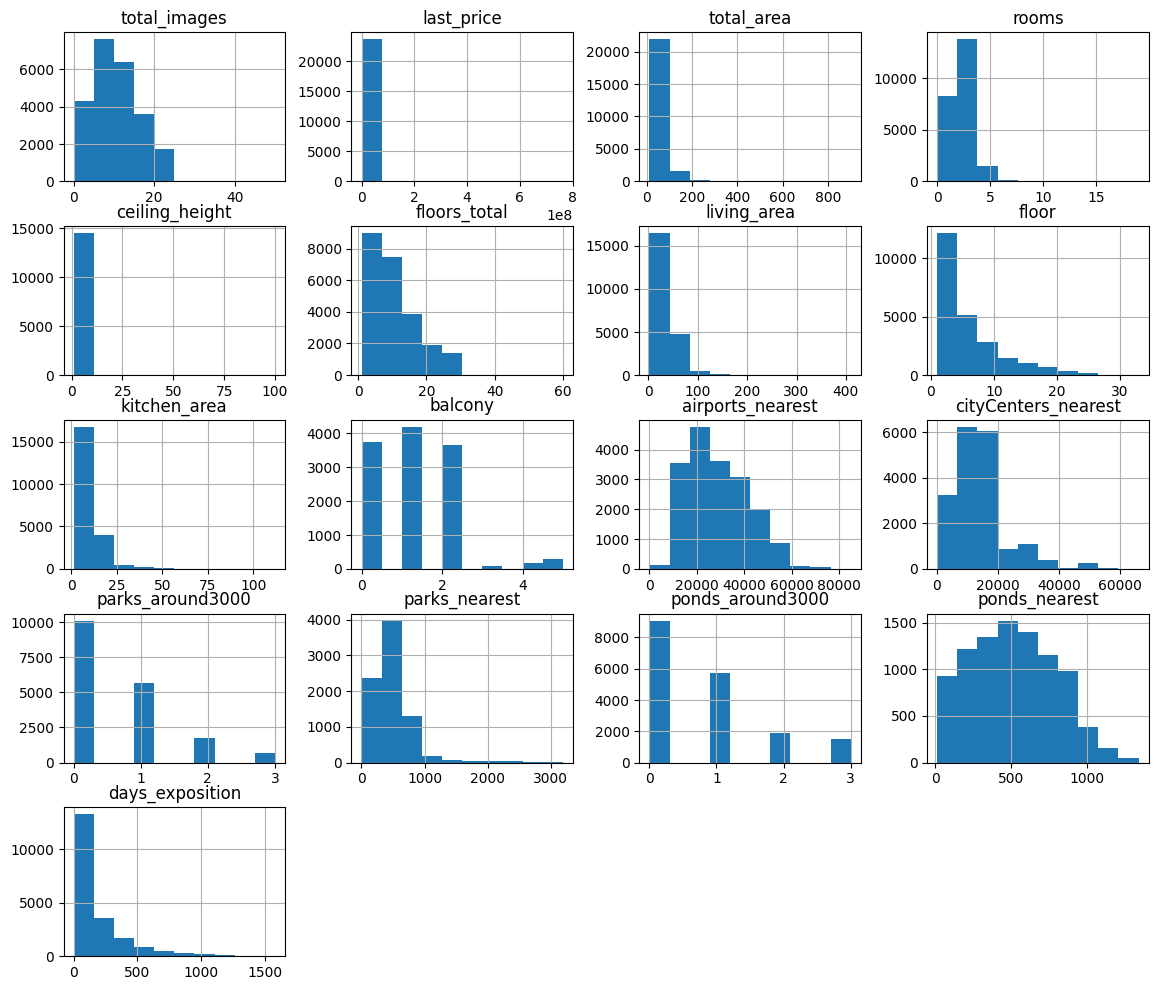

In [7]:
df.hist(figsize = (14, 12));

Все гистограммы смещены влево. То есть в основном мы будем иметь дело с распределением Пуассона.

##### Вывод:
На входе имеем датасет размерностью 23699 х 22, с пропущеными значениями. В первом приближении датасет соответствует реальности. Похоже что цифровые столбцы в датасете следуют распределению Пуассона.

### Предобработка данных

#### Заполнение пропущенных значений

In [8]:
# столбцы в которых есть пропущенные значения
pd.DataFrame(round(df.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


В 12 столбцах есть пропущенные значения.

In [9]:
# Частота с которой встречаются отсутвующие значения в зависимости от этажности дома
print('количество этажей /', 'сколько раз пропущена высота потолков')
print(df[df.ceiling_height.isna()]['floors_total'].value_counts())
df.loc[df.ceiling_height.isna(), 'ceiling_height'] = df.ceiling_height.median()

количество этажей / сколько раз пропущена высота потолков
floors_total
5.0     2122
9.0     1204
25.0     552
16.0     511
12.0     509
10.0     424
4.0      411
17.0     330
6.0      295
3.0      269
24.0     252
18.0     230
14.0     210
19.0     205
7.0      194
8.0      170
2.0      168
23.0     156
22.0     145
15.0     140
20.0     115
13.0     112
11.0      94
21.0      93
27.0      92
26.0      70
35.0      16
1.0       15
28.0      12
36.0       1
33.0       1
Name: count, dtype: int64


Видно что пропущеных значений больше всего в зданиях где 5 этажей, скорее всего это так называемые хрущевки. Можно было бы предположить что у них одинаковая высота потолков, но поиск в интернете показал что высота потолков в хрущевках может быть от 2.45 до 2.7 метров. С другой стороны если бы в квартирах были очень высокие потолки, то хозяева скорее всего удосужились бы это указать, так как это является преимуществом при продаже квартиры. Заполняю все пропущенные значения медианой, так как мы не фильтровали выбросы.

In [10]:
# Квартиры в которых не указано количество этажей в доме
print(df[df.floors_total.isna()].floor.value_counts())
print('всего не указано количество этажей в доме:')
print(df.floors_total.isna().sum())

floor
4     10
6      9
8      8
12     6
9      5
21     4
5      4
7      4
3      4
19     3
11     3
13     3
1      3
18     3
15     3
10     3
24     2
2      2
20     2
14     2
22     1
17     1
23     1
Name: count, dtype: int64
всего не указано количество этажей в доме:
86


In [11]:
df[df.floors_total.isna()].query('floor == 4').T

,186,1930,8986,10351,10486,10568,11425,12352,12399,14153
total_images,12,1,10,4,5,12,1,5,0,1
last_price,11640000.0,9750000.0,4850000.0,5380992.0,6300000.0,14900000.0,2100000.0,19900000.0,2895000.0,1995000.0
total_area,65.2,66.77,103.1,110.72,68.2,100.0,25.53,124.32,29.61,23.17
first_day_exposition,2018-10-02T00:00:00,2016-05-13T00:00:00,2018-07-10T00:00:00,2015-10-09T00:00:00,2018-04-01T00:00:00,2018-10-02T00:00:00,2016-05-10T00:00:00,2018-08-03T00:00:00,2019-01-29T00:00:00,2016-06-22T00:00:00
rooms,2,2,3,4,2,3,1,3,1,1
ceiling_height,2.65,2.65,2.65,2.65,2.65,2.8,2.65,2.65,2.65,2.65
floors_total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
living_area,30.8,NaN,68.1,80.39,NaN,51.0,NaN,NaN,14.16,NaN
floor,4,4,4,4,4,4,4,4,4,4
is_apartment,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В 86 случаях не указано количество этажей в доме. В лидерах почему-то четвертый этаж. Но общих закономерностей кроме как то что не указана также высота потолков не выявляется. Так как значений мало и какой-то тенденции не прослеживается, оставлю как есть.

In [12]:
print('не указана жилая площадь количество комнат/кол-во пропусков')
print(df[df.living_area.isna()].rooms.value_counts())
print('общее число квартир где не указана жилая площади')
print(df[df.living_area.isna()].rooms.value_counts().sum())
print('медианные значения квадратуры жилой площади для соответсвующего количества комнат')
print(living_area := df.pivot_table(index = 'rooms', values = 'living_area', aggfunc='median').to_dict())
# Заполнение пропусков
for rooms_number, area in living_area['living_area'].items(): 
    df.living_area.mask((df['living_area'].isna()) & (df['rooms'] == rooms_number), area, inplace=True)

не указана жилая площадь количество комнат/кол-во пропусков
rooms
1    659
2    644
3    448
4     91
5     34
0     14
7      6
6      6
9      1
Name: count, dtype: int64
общее число квартир где не указана жилая площади
1903
медианные значения квадратуры жилой площади для соответсвующего количества комнат
{'living_area': {0: 18.0, 1: 17.6, 2: 30.5, 3: 45.0, 4: 63.6, 5: 91.785, 6: 123.9, 7: 145.0, 8: 161.0, 9: 179.2, 10: 161.4, 11: 133.9, 12: 409.7, 14: 195.15, 15: 409.0, 16: 180.0, 19: 264.5}}


Выше посчитано количество квартир с не указанной жилой площадью по комнатам, общее количество таких квартир и медианное количество жилой площади в зависимости от количества комнат. Пропущенные значения можно заполнить медианными для соответсвующего количества комнат.


In [13]:
# Является ли квартира апартаментами
print(df.is_apartment.value_counts())
# Всего пропущеных
print(sum(df.is_apartment.isna()))

is_apartment
False    2725
True       50
Name: count, dtype: int64
20924


Проверка на то сколько квартир является апартаментами. Апартаменты - нежилая недвижимость в которой можно жить. В подавляющем большинстве случаев не указано ничего. Апартаменты составляют только 2 процента от объявлений где указан тип недвижимости. Обычно апартаменты дешевле аналогичной по квадратуре квартиры, но поскольку я не могу достоверно заполнить пропуски то этот столбец я не буду учитывать.

In [14]:
# заполним пропущенные значения в столбце living_area (жилая площадь)
living_area = df.pivot_table(index='rooms', values='living_area', aggfunc='median').reset_index()
living_area.apply(
    lambda x: df.loc[(df['rooms']==x.rooms) & (df['living_area'].isna()), 'living_area'].fillna(x.living_area),
    axis=1)
sum(df.living_area.isna())

0

Для заполнения пропущенных значений в столбце living_area(жилая площадь) были взяты медианные значения для квартир, медианы были рассчитаны группировкой по количеству комнат.

In [15]:
# заполним пропущенные значения в столбце kitchen_area (площадь кухни)
kitchen_area = df.groupby('rooms').agg({'kitchen_area':'median'})
for row in kitchen_area.iterrows():
    df.loc[(df['rooms'] == row[0]) & (df.kitchen_area.isna()), 'kitchen_area'].fillna(row[1][0])

Для заполнения пропущенных значений в столбце kitchen_area(площадь кухни) были взяты медианные значения для квартир, медианы были рассчитаны группировкой по количеству комнат.

In [16]:
# заполним пропущенные значения в количестве балконов
print('всего квартир:', len(df), 'указано количество балконов:', len(df) - sum(df.balcony.isna()))
balcony = df.pivot_table(index='floor', values='balcony', columns='rooms', aggfunc='median')
balcony = balcony.applymap(int, na_action='ignore')
for row in balcony.iterrows():
    for room, bnumber in row[1].items():
        df.loc[(df['floor'] == row[0]) & 
               (df.balcony.isna()) & 
               (df.rooms == room), 'balcony'].fillna(bnumber)

всего квартир: 23699 указано количество балконов: 12180


Количество балконов не указано почти что в половине случаев, по всей видимости люди считают эту информацию не очень то важной. Количество балконов было заполнено медианными значениями исходя из этажа здания и количества комнат в квартире.

In [17]:
# Заполним столбец название населённого пункта(locality_name)
df.loc[df.locality_name.isna(), 'locality_name'] = 'Санкт-Петербург'

В столбце locality_name было очень не много (десятки) пропущенных значений, заполнил их названием "Санкт-Петербург", так как оно является наиболее вероятным.

In [18]:
# Заполним столбец апартаменты(is_apartment)
print(df.is_apartment.unique())
df.is_apartment.fillna('False', inplace=True)

[nan False True]


Заменил пустые значения на False, как наиболее вероятные. Если объект является апартаментами, то об это скорее всего укажут.

__Вывод__: Медианными значениями были заполнены столбцы: ceiling_height, living_area, kitchen_area и balcony. Предположения исходя из которых рассчитывалась медиана для заполнения столбцов:
- ceiling_height - по этажности здания,
- living_area - по количеству комнат,
- kitchen_area - по количеству комнат,
- balcony - по этажности и количеству комнат.

Дополнительно отсутствующие значения были заменены на False в столбце is_appartment, поскольку основной фонд недвижимости состоит всё таки не из апартаментов, а обычных квартир. Остальные столбцы заполнить не представляется возможным, так как они либо вычисляемые, либо не от чего оттолкнуться при рассчете возможных значений для заполнения.
Пустые значения появляются по всей видимости из-за того что в форме создания объявления БД много не обязательных для заполнения полей и полей без значения по умолчанию. Соответственно они не передаются на сервер и БД автоматически подставляет null.

#### Конвертация типов данных

In [19]:
# Сравним типы данных в столбцах с тем что имеем по факту
display(df.info())
df.head().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

None

,0,1,2,3,4
total_images,20,7,10,0,2
last_price,13000000.0,3350000.0,5196000.0,64900000.0,10000000.0
total_area,108.0,40.4,56.0,159.0,100.0
first_day_exposition,2019-03-07T00:00:00,2018-12-04T00:00:00,2015-08-20T00:00:00,2015-07-24T00:00:00,2018-06-19T00:00:00
rooms,3,1,2,3,2
ceiling_height,2.7,2.65,2.65,2.65,3.03
floors_total,16.0,11.0,5.0,14.0,14.0
living_area,51.0,18.6,34.3,45.0,32.0
floor,8,1,4,9,13
is_apartment,False,False,False,False,False


In [20]:
df.first_day_exposition = pd.to_datetime(df.first_day_exposition, yearfirst=True)
df.is_apartment = df.is_apartment == 'True'

__Вывод__: Поменяны типы у двух столбцов first_day_exposition - на datetime и is_apartment на bool

#### Обработка столбца locality_name

In [21]:
df['locality_name'] = df.locality_name.str.replace('ё', 'е')


def levenshtein_distance_percentage(s1: str, s2: str) -> float:
    """Computes the Levenshtein distance"""
    s1 = s1.replace(
        'поселок городского типа', ''
    ).replace(
        'городской поселок', ''
    ).replace(
        'поселок', ''
    ).replace(
        'деревня', ''
    ).strip()
    s2 = s2.replace(
        'поселок городского типа', ''
    ).replace(
        'городской поселок', ''
    ).replace(
        'поселок', ''
    ).replace(
        'деревня', ''
    ).strip()
    assert min(len(s1), len(s2)) > 0, "One of the given string is empty"
    return 1. - distance(s1, s2) / min(len(s1), len(s2))


df.locality_name = df.locality_name.str.lower().str.replace('поселок', 'посёлок')


{place:place_c for place_c in df.locality_name.unique() 
 for place in df.locality_name.unique() if (place != place_c) 
 and (levenshtein_distance_percentage(place, place_c) > 0.7)}

{'посёлок бугры': 'посёлок шушары',
 'посёлок лукаши': 'посёлок ромашки',
 'посёлок ушаки': 'посёлок лукаши',
 'посёлок пушное': 'посёлок плоское',
 'городской посёлок павлово': 'городской посёлок рощино',
 'городской посёлок назия': 'городской посёлок рощино',
 'городской посёлок виллози': 'городской посёлок рощино',
 'городской посёлок будогощь': 'городской посёлок рощино',
 'городской посёлок рощино': 'городской посёлок будогощь',
 'посёлок терволово': 'посёлок громово',
 'посёлок щеглово': 'посёлок громово',
 'посёлок гаврилово': 'посёлок громово',
 'посёлок углово': 'посёлок громово',
 'посёлок кобралово': 'посёлок гарболово',
 'посёлок перово': 'посёлок громово',
 'посёлок гарболово': 'посёлок громово',
 'посёлок громово': 'посёлок гарболово',
 'посёлок аннино': 'посёлок калитино',
 'посёлок репино': 'посёлок перово',
 'посёлок семрино': 'посёлок перово',
 'посёлок сумино': 'посёлок пушное',
 'посёлок кикерино': 'посёлок калитино',
 'посёлок починок': 'посёлок пушное',
 'кудрово'

In [22]:
df.replace(
    {'locality_name': {
        'деревня гарболово': 'посёлок гарболово',
        'мурино': 'посёлок мурино',
        'кудрово': 'деревня кудрово',
        'городской посёлок фёдоровское': 'деревня фёдоровское',
        'городской посёлок советский': 'посёлок городского типа советский',
        'городской посёлок павлово': 'посёлок городского типа павлово',
        'деревня калитино': 'посёлок калитино',
        'городской посёлок рощино': 'посёлок городского типа рощино',
        'деревня щеглово': 'посёлок щеглово',
        'посёлок рябово': 'посёлок городского типа рябово',
        'любань': 'посёлок любань',
        'городской посёлок большая ижора': 'посёлок городского типа большая ижора',
        'городской посёлок лесогорский': 'посёлок городского типа лесогорский',
        'деревня зимитицы': 'посёлок зимитицы',
        'городской посёлок мга': 'посёлок городского типа мга',
        'городской посёлок назия': 'посёлок городского типа назия',
        'деревня рабитицы': 'посёлок рабитицы',
    }},
    inplace=True
)

__Вывод__: При помощи функции дистанции Левенштейна были найдены совпадения в названиях мест. Совпадающие названия мест с разными написаниями были переименованы. Значение для фильтрации совпадений было подобрано эмпирически.

#### Фильтрация выбросов

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

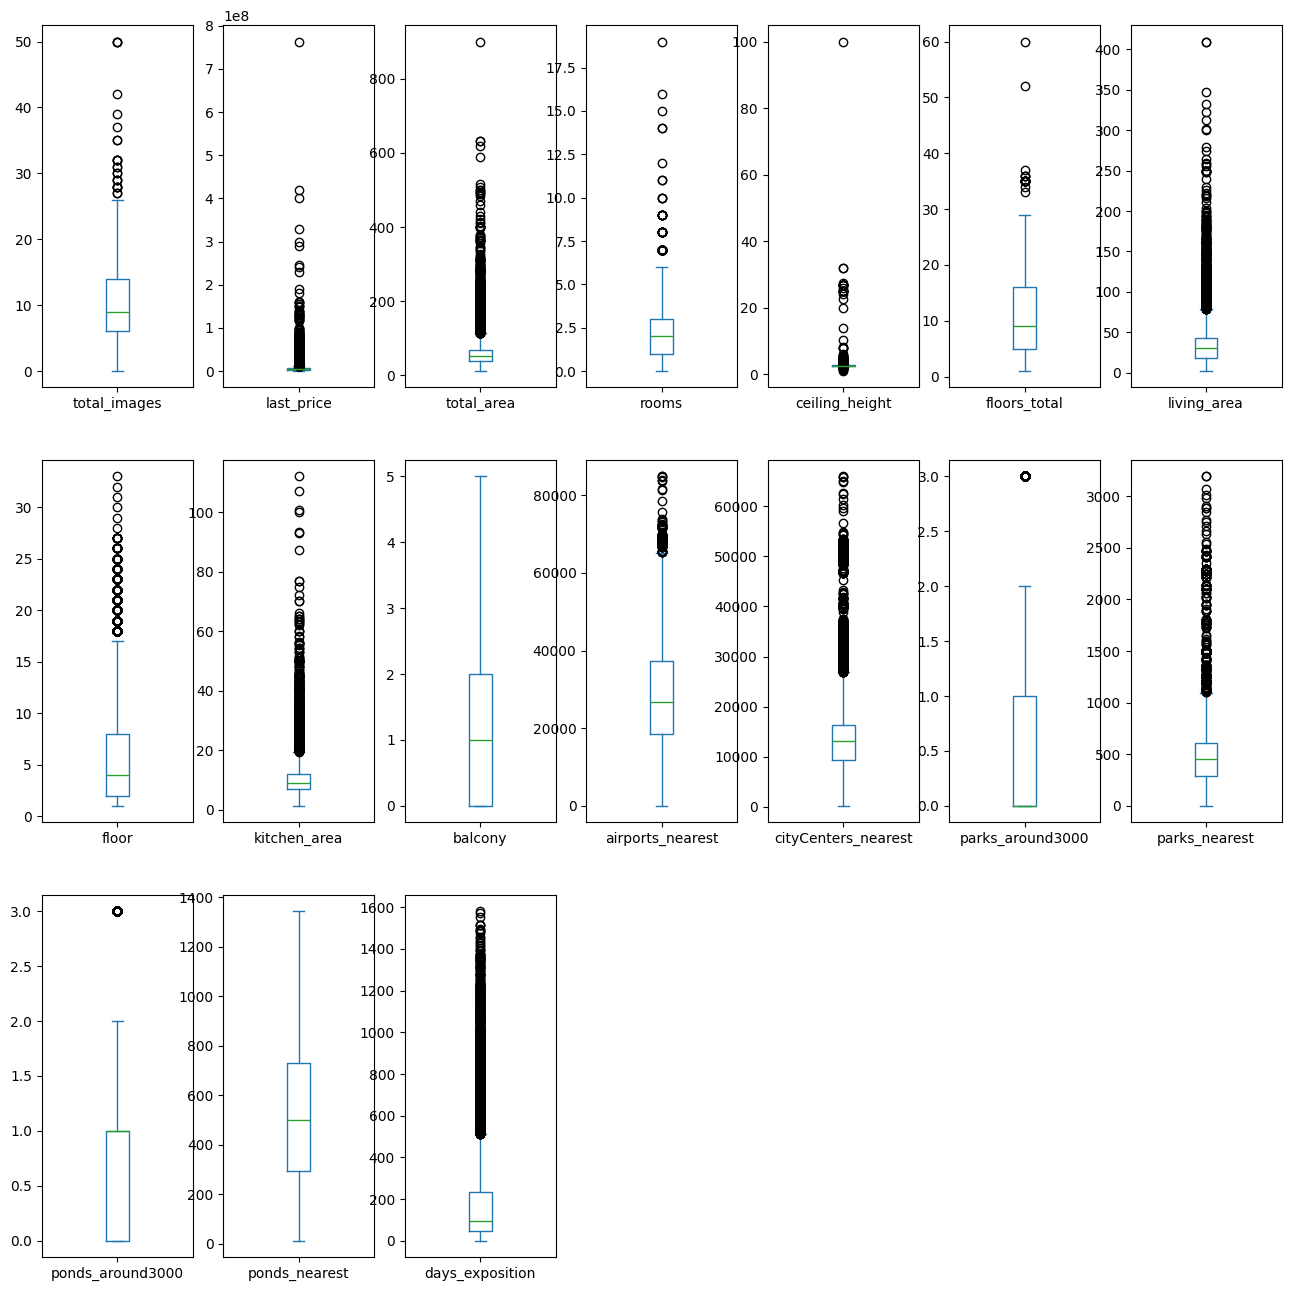

In [24]:
df.plot(kind = 'box', subplots=True, figsize=(16, 16), layout=(3,7));

Как и на гистограммах в первом разделе видно что в основном мы имеем дело с распределением Пуассона. Фильтрацию значений начну с удаления больше 250 квадратных метров, такие - штучный товар, и выбросив их возможно получится избавиться от выбросов и в других столбцах.

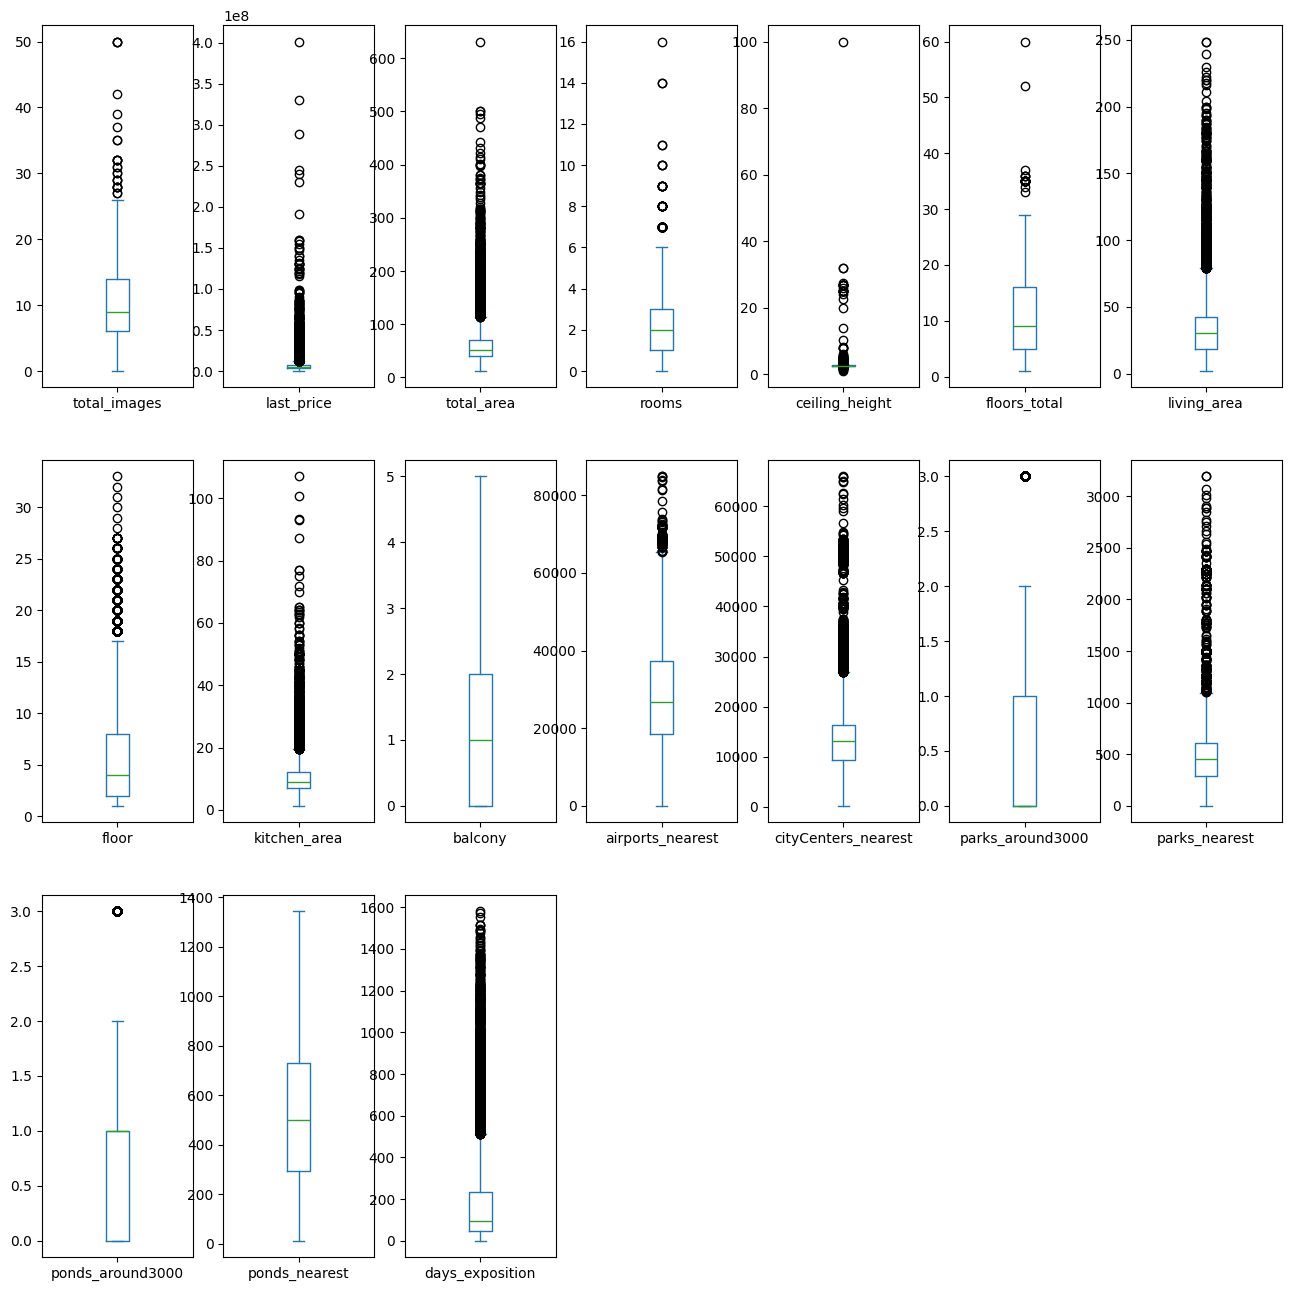

In [25]:
df = df.query('living_area < 250')
df.plot(kind = 'box', subplots=True, figsize=(16, 16), layout=(3,7));

In [26]:
# Разберемся с kitchen_area
display(df.query('kitchen_area > living_area'))
display(df.query('(kitchen_area > 50) and (kitchen_area > living_area)').T)
display(df.query('kitchen_area > total_area/2'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,...,41.00,NaN,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.60,6,False,...,14.40,1.0,посёлок парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
51,7,45000000.0,161.00,2017-10-17,3,3.20,8.0,38.00,4,False,...,50.00,NaN,санкт-петербург,32537.0,6589.0,0.0,NaN,3.0,99.0,541.0
53,7,4300000.0,39.10,2017-11-10,1,2.65,25.0,15.40,13,False,...,15.50,2.0,посёлок парголово,52611.0,18783.0,0.0,NaN,0.0,NaN,6.0
101,4,3000000.0,37.00,2019-03-23,1,2.75,10.0,12.00,3,False,...,13.00,NaN,садовое товарищество новая ропша,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23388,7,5400000.0,43.00,2017-04-24,1,2.65,18.0,12.00,8,False,...,20.00,0.0,санкт-петербург,25108.0,15940.0,0.0,NaN,0.0,NaN,124.0
23481,1,3000000.0,37.29,2019-04-15,1,2.65,19.0,10.08,10,False,...,16.88,NaN,санкт-петербург,37006.0,15157.0,0.0,NaN,0.0,NaN,7.0
23573,8,6290000.0,47.67,2019-03-20,1,3.60,12.0,13.59,12,False,...,17.87,2.0,санкт-петербург,35726.0,16028.0,1.0,253.0,2.0,99.0,19.0
23574,14,64990000.0,139.00,2015-11-24,3,3.00,8.0,3.00,8,False,...,16.00,1.0,санкт-петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


,3561,4320,6021,8261,8709,14644,14900,15780,16239,16647,16797,16964,17912,19130,19382,19499,20215
total_images,5,20,19,20,19,17,20,9,5,15,9,15,17,11,9,10,2
last_price,12300000.0,19700000.0,16830000.0,36000000.0,24500000.0,47000000.0,25900000.0,12990000.0,82400000.0,122000000.0,65850000.0,16500000.0,135000000.0,40000000.0,20786000.0,8000000.0,85000000.0
total_area,115.0,146.3,117.4,123.2,105.0,150.0,125.6,119.6,181.1,145.0,146.0,101.3,166.0,153.0,109.0,118.0,249.7
first_day_exposition,2017-08-09 00:00:00,2017-02-10 00:00:00,2019-04-04 00:00:00,2018-01-14 00:00:00,2017-04-20 00:00:00,2017-02-28 00:00:00,2018-08-14 00:00:00,2017-03-13 00:00:00,2017-05-24 00:00:00,2017-04-25 00:00:00,2017-07-14 00:00:00,2017-12-18 00:00:00,2019-02-07 00:00:00,2017-09-02 00:00:00,2018-07-16 00:00:00,2017-08-31 00:00:00,2018-02-01 00:00:00
rooms,3,3,2,1,2,4,2,3,3,3,2,3,3,3,2,3,3
ceiling_height,2.7,3.4,2.75,3.0,3.2,3.7,4.0,3.0,3.9,3.3,2.65,2.8,3.3,3.3,3.0,3.0,2.65
floors_total,20.0,6.0,16.0,14.0,6.0,6.0,4.0,5.0,9.0,6.0,9.0,18.0,7.0,10.0,7.0,5.0,10.0
living_area,45.0,55.8,33.4,31.2,31.1,58.0,42.7,36.4,58.2,36.0,40.0,32.9,52.0,45.2,30.5,36.0,72.0
floor,16,6,13,7,2,5,4,4,4,2,3,10,1,7,4,4,9
is_apartment,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
511,7,5950000.0,69.00,2017-12-21,1,2.65,16.0,13.00,12,False,...,50.00,1.0,посёлок мурино,NaN,NaN,NaN,NaN,NaN,NaN,56.0
680,14,7200000.0,43.00,2017-10-31,1,2.65,8.0,9.00,2,False,...,23.00,NaN,санкт-петербург,23900.0,5232.0,1.0,2137.0,1.0,933.0,296.0
696,1,3364930.0,34.69,2014-11-27,1,2.64,25.0,23.43,25,False,...,23.43,2.0,санкт-петербург,43396.0,12153.0,0.0,NaN,0.0,NaN,574.0
1326,8,8100000.0,52.00,2017-01-29,2,2.70,25.0,9.00,15,False,...,32.00,2.0,санкт-петербург,35555.0,15561.0,0.0,NaN,1.0,1180.0,337.0
1336,12,18500000.0,66.00,2017-06-08,1,3.00,7.0,25.00,7,False,...,35.00,1.0,санкт-петербург,NaN,NaN,NaN,NaN,NaN,NaN,130.0
1407,9,3250000.0,24.60,2018-06-29,1,2.65,25.0,18.00,16,False,...,18.20,NaN,санкт-петербург,35250.0,16414.0,0.0,NaN,1.0,400.0,96.0
2309,10,4200000.0,62.40,2017-06-15,2,2.60,9.0,8.40,6,False,...,41.00,2.0,посёлок шушары,23662.0,29448.0,0.0,NaN,0.0,NaN,111.0
2443,18,15000000.0,72.00,2016-04-25,2,3.66,5.0,21.30,5,False,...,37.80,0.0,санкт-петербург,22990.0,2445.0,2.0,508.0,1.0,267.0,85.0
3290,13,3400000.0,42.30,2017-01-24,1,2.70,20.0,11.90,3,False,...,21.90,0.0,посёлок мурино,NaN,NaN,NaN,NaN,NaN,NaN,14.0
3561,5,12300000.0,115.00,2017-08-09,3,2.70,20.0,45.00,16,False,...,60.00,1.0,санкт-петербург,33386.0,14234.0,0.0,NaN,0.0,NaN,63.0


Столбец kitchen_area привлек моё внимание тем что в нём много выбросов, но при более близком рассмотрении столбцов с явными опечатками, где, например, площадь кухни превышает общую площадь квартиры не было найдено. Возможно в некоторых случаях кухня совмещённая с гостиной.

In [27]:
pd.options.mode.chained_assignment = None
# Отфильтруем ceiling_height
display(df.query('(ceiling_height > 4)').ceiling_height.unique())
df['ceiling_height'] = df.ceiling_height.mask(df.ceiling_height >= 20, 2.65)
display(ceilings := df.query('(ceiling_height < 2.3)').ceiling_height.unique())
df.query('ceiling_height.isin(@ceilings)')
# меньше 2.4 метров жильё не строят, судя по таблице все подобные записи являются квартирами, поэтому медиана
df.loc[df.ceiling_height <= 2.3, 'ceiling_height'] = 2.65

array([  4.15,  25.  ,   5.2 ,   5.3 ,   5.  ,   4.06,   4.7 ,   5.6 ,
         4.19,   4.8 ,   4.5 ,   4.2 ,  32.  ,   8.  ,   4.37,  27.  ,
         4.1 ,  24.  ,  26.  ,   8.3 ,   4.4 ,   4.45,   5.5 ,   4.3 ,
        14.  ,   4.14,   4.25,  20.  ,   6.  ,  22.6 ,   5.8 ,  27.5 ,
         4.9 ,  10.3 , 100.  ])

array([2.  , 1.2 , 2.2 , 1.75, 2.25, 1.  ])

In [28]:
display(df.query('(ceiling_height > 4)'))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
154,1,8200000.0,80.0,2018-11-06,3,4.15,3.0,44.200,2,False,...,12.2,NaN,санкт-петербург,20562.0,3167.0,2.0,344.0,1.0,838.0,38.0
464,15,66571000.0,280.3,2015-06-11,6,5.20,8.0,159.500,7,False,...,21.1,0.0,санкт-петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0
1026,20,155000000.0,310.0,2018-10-12,5,5.30,3.0,190.000,3,False,...,63.0,2.0,санкт-петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1053,13,550000.0,29.0,2018-02-01,1,5.00,3.0,17.600,1,False,...,NaN,NaN,бокситогорск,NaN,NaN,NaN,NaN,NaN,NaN,6.0
1129,20,6695000.0,36.9,2018-09-28,1,4.06,5.0,22.000,2,False,...,7.2,NaN,санкт-петербург,21725.0,2990.0,1.0,596.0,1.0,866.0,110.0
1300,14,120000000.0,280.0,2018-07-12,5,4.70,4.0,162.000,3,False,...,30.0,NaN,санкт-петербург,24680.0,4247.0,1.0,464.0,3.0,339.0,225.0
1388,20,59800000.0,399.0,2015-01-21,5,5.60,6.0,91.785,6,False,...,NaN,0.0,санкт-петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
2639,17,4850000.0,59.7,2017-11-18,3,4.19,5.0,46.300,4,False,...,6.4,1.0,санкт-петербург,42964.0,15468.0,0.0,NaN,0.0,NaN,60.0
2802,7,14950000.0,50.0,2016-03-06,2,4.80,3.0,30.000,2,False,...,10.0,0.0,санкт-петербург,24433.0,1725.0,1.0,589.0,3.0,161.0,160.0
2823,8,2700000.0,39.0,2018-02-01,1,4.50,6.0,18.300,6,False,...,8.4,NaN,посёлок городского типа токсово,NaN,NaN,NaN,NaN,NaN,NaN,NaN


От выбросов в столбце ceiling_height избавились.

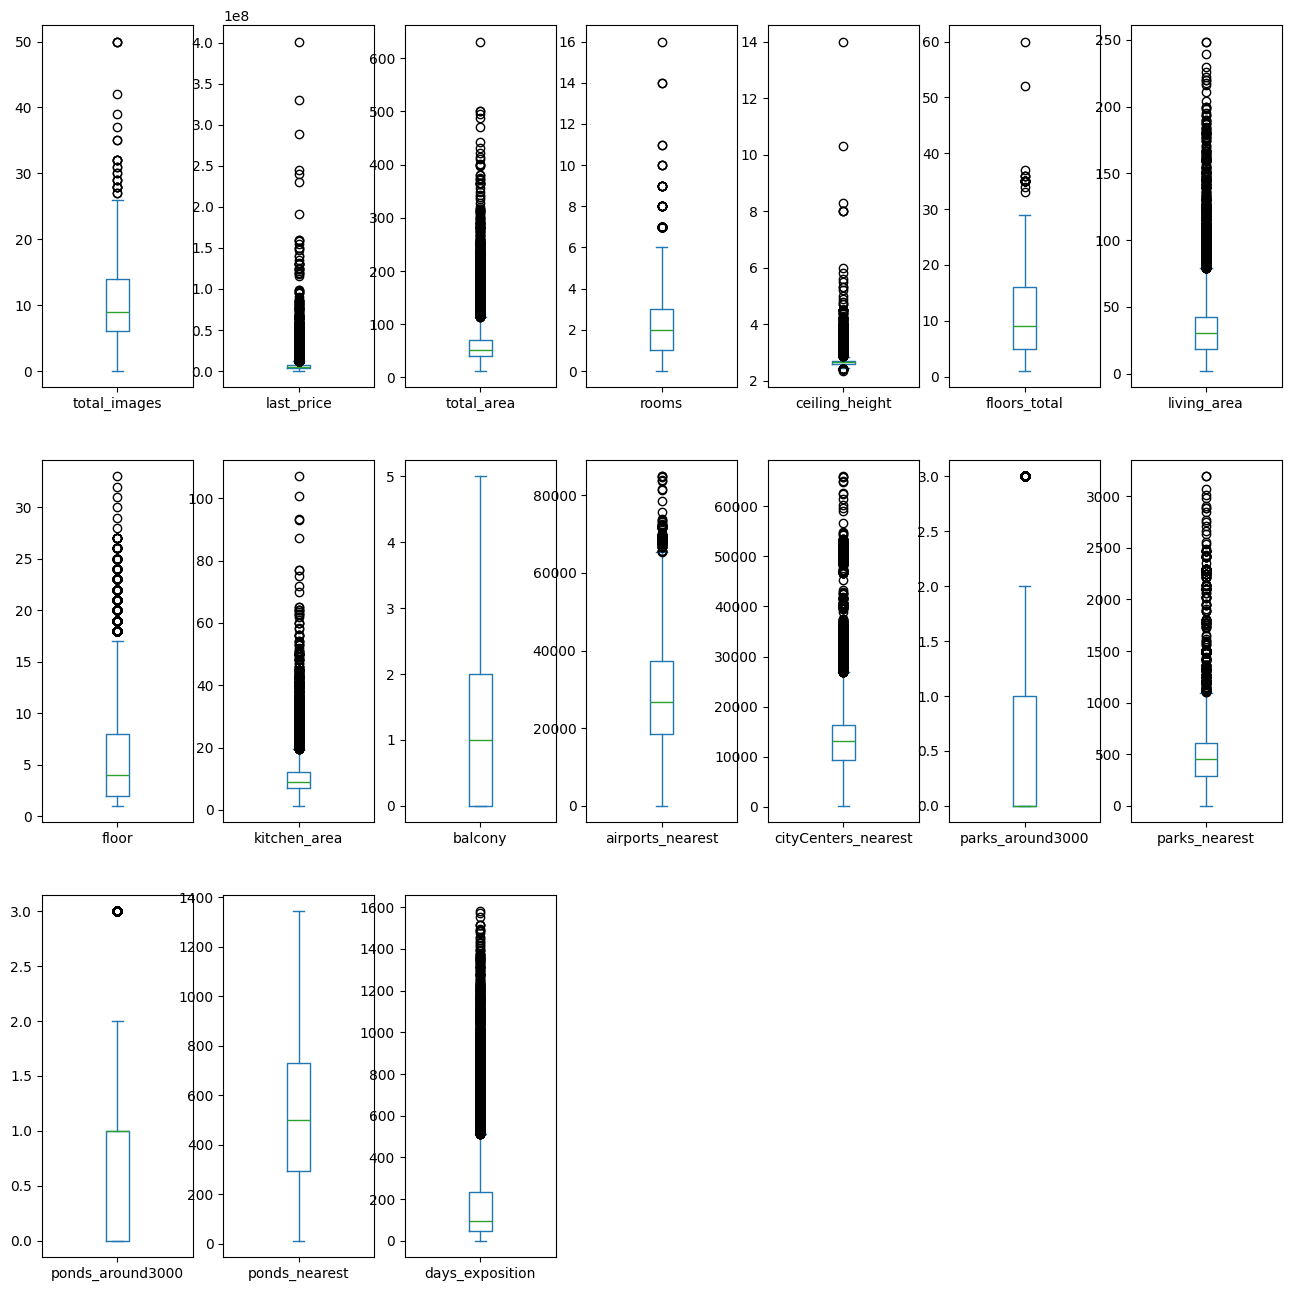

In [29]:
df = df.query('living_area < 250')
df.plot(kind = 'box', subplots=True, figsize=(16, 16), layout=(3,7));

__Вывод__: В ходе работы были убраны выбросы из столбцов living_area и ceiling_height.

Присвоил 0 все пропущенным балконам.

In [30]:
df.loc[df.balcony.isna(), 'balcony'] = 0

Проверим датасет на дубликаты.

In [31]:
print('количество дубликатов =', sum(df.duplicated()))

количество дубликатов = 0


### Посчитайте и добавьте в таблицу новые столбцы

In [32]:
# цена квадратного метра
df['sq_meter_price'] = df.last_price/df.total_area
# цена жилого квадратного метра
df['living_sq_meter_price'] = df.last_price/df.living_area
# День недели публикации
df['day_of_week'] = df.first_day_exposition.dt.day_of_week
df['month'] = df.first_day_exposition.dt.month
df['year'] = df.first_day_exposition.dt.year
df['flat_type'] = df.apply(
    lambda x: "первый" if x.floor == 1 else ("последний" if x.floor == x.floors_total else "другой"), axis=1
)
df['center_distance_km'] = (df.cityCenters_nearest/1000).round()

### Проведите исследовательский анализ данных

#### Параметры объектов

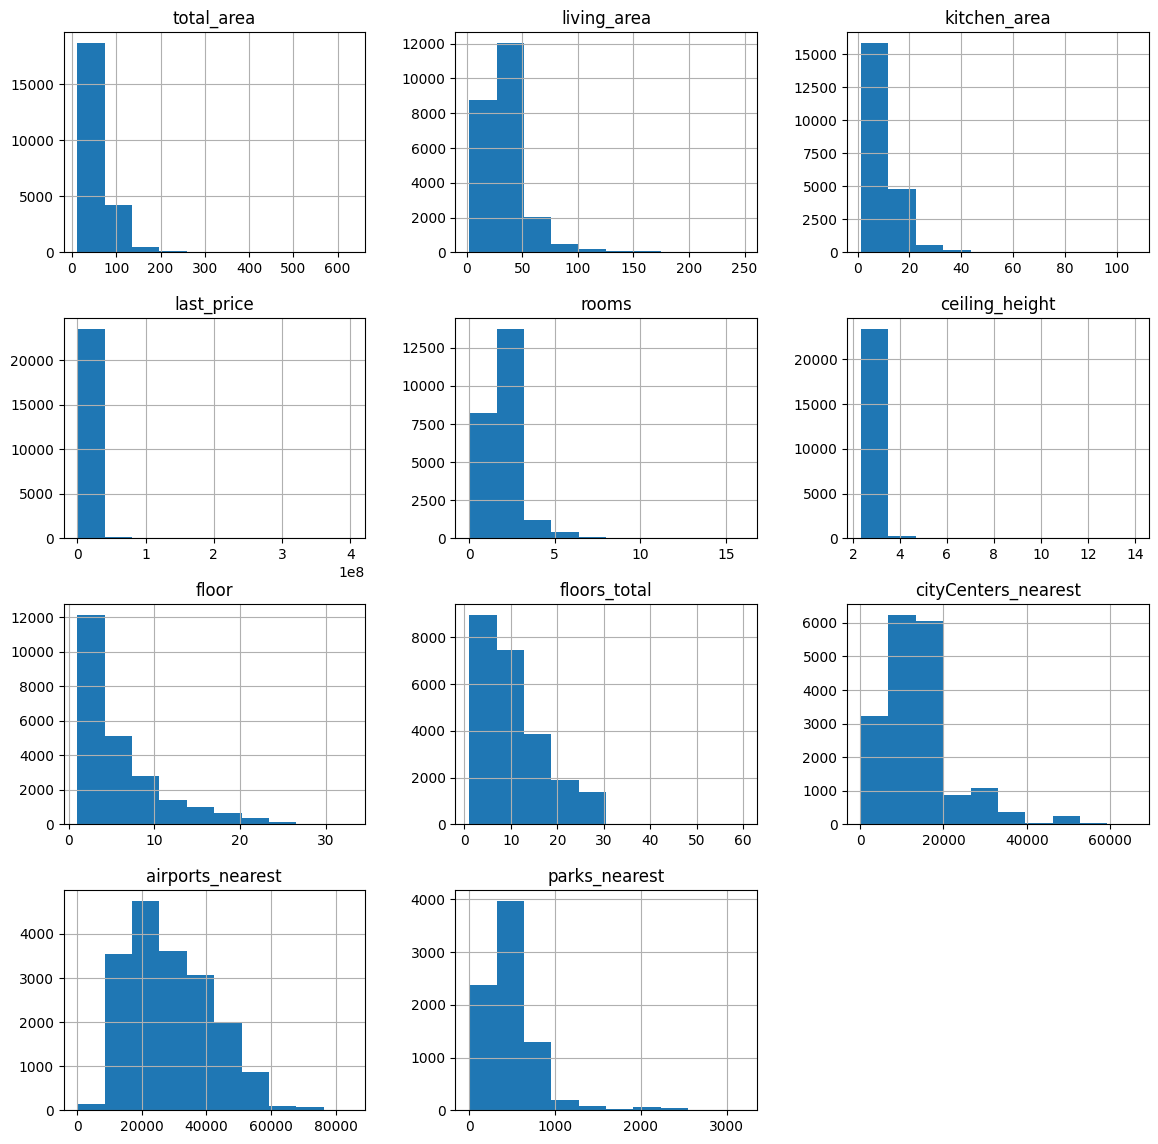

In [33]:
# Построим гистограммы для числовых столбцов
df.hist(column=['total_area', 'living_area', 'kitchen_area', 'last_price', 'rooms', 'ceiling_height'
                , 'floor', 'floors_total','cityCenters_nearest', 'airports_nearest', 'parks_nearest'], 
        figsize=(14, 14));

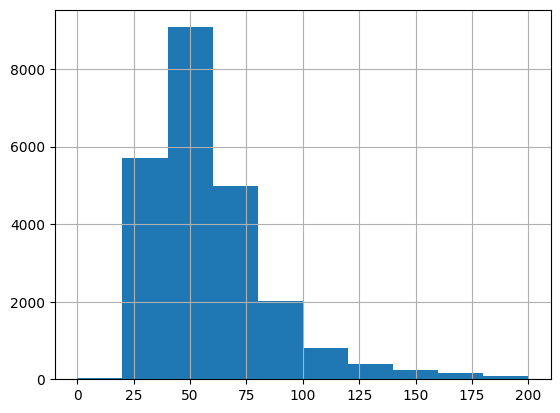

In [34]:
df.total_area.hist(range=(0, 200));

При ограничений максимальных и минимальных значений стало видно что присутствует категория квартир менее 25 метров, скорее всего это комнаты в коммуналках.

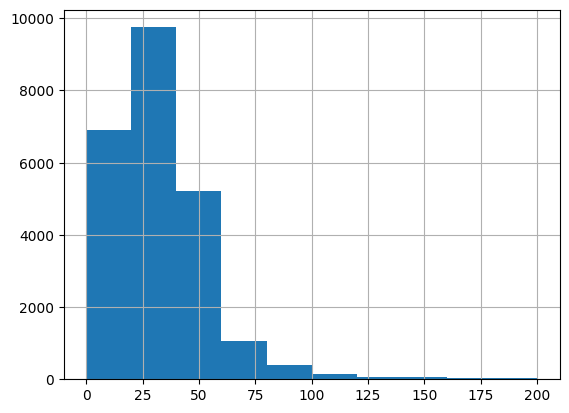

In [35]:
df.living_area.hist(range=(0,200));

А в жилой площади похоже коммуналки уравниваются с однокомнатными, так как если брать к примеру однокомнатную квартиру, то половина площади будет не жилой(кухня, коридор, ванная), поэтому нет выраженной корзины с малым количеством случаев между 0 и 25 квадратных метров как в случае с total_area.

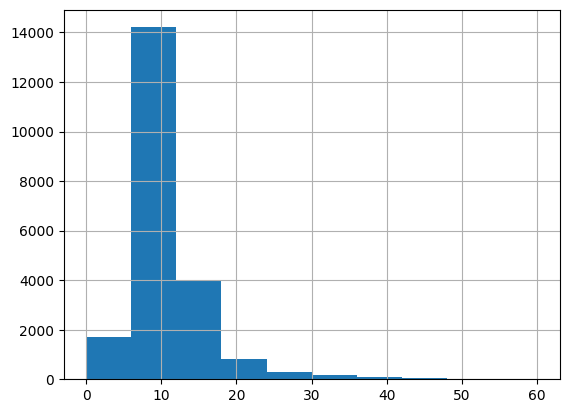

In [36]:
df.kitchen_area.hist(range=(0, 60));

И опять ограничение возможного диапазона значений позволило увидеть корзину с кухнями меньше 8 квадратных метров, быстрый гуглёж выдал что такие кухни обычно в так называемых хрущевках.

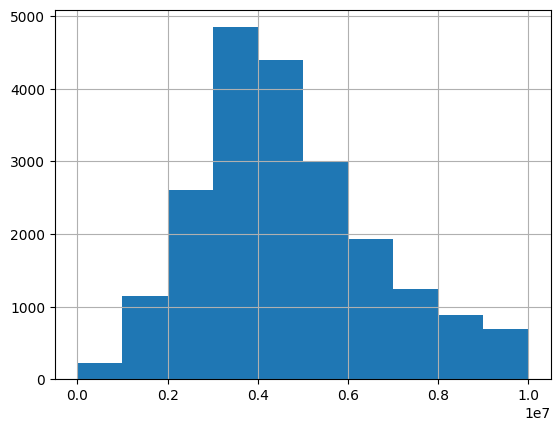

In [37]:
df.last_price.hist(range=(0, 0.1e8));

Интересно что при уменьшении диапазона для значений до 10 миллионов, интуитивно такие цены на самые ходовые квартиры, распределение кажется почти нормальным, больше всего предложений за 3-4 миллиона рублей.

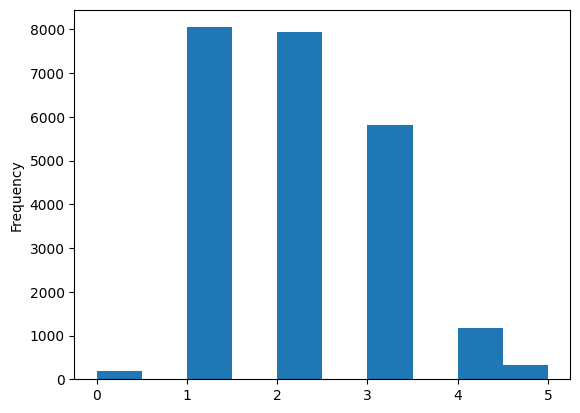

In [38]:
df.rooms.plot(kind='hist', range=(0,5));

На рынке больше всего 1 и 2 комнатных квартир. Интересно что это за квартиры где количество комнат 0.

In [39]:
print('всего 0 комнат:', sum(df.rooms == 0))
print('студий:', sum(df[df.rooms == 0].studio))
print('открытая планировка:', sum(df[df.rooms == 0].open_plan))

всего 0 комнат: 197
студий: 138
открытая планировка: 59


Выясняется что это либо студии, либо квартиры с открытой планировкой.

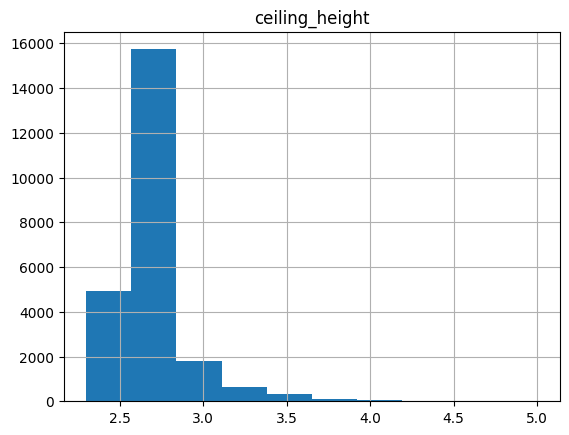

In [40]:
df.hist('ceiling_height', range=(2.3, 5));

Опять же при уменьшении диапазона стало видно что есть значительное количество квартир с потолками меньше медианных 2.65 метров.

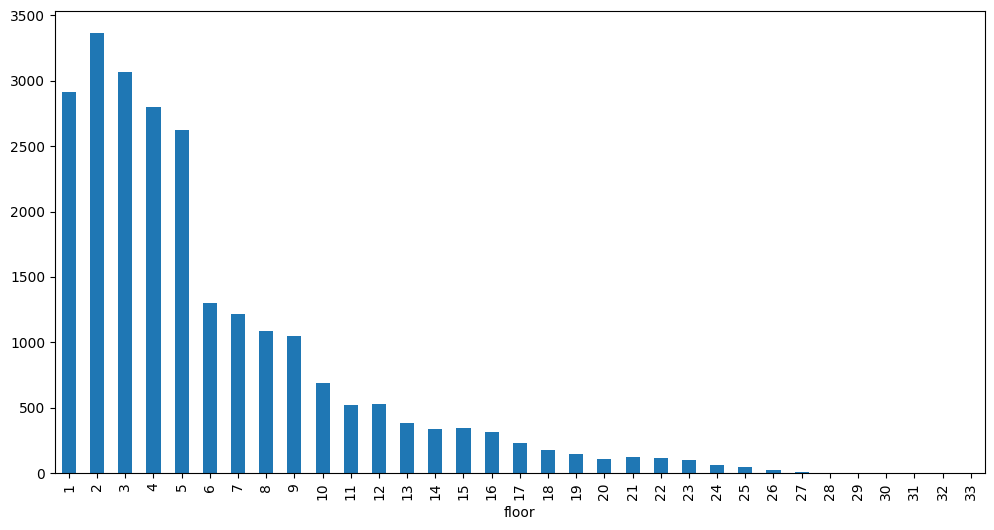

In [41]:
df.floor.value_counts().sort_index().plot(kind='bar', figsize=(12, 6));

Сразу бросается в глаза что квартир на первых этажах продают меньше чем на вторых. Обычно на первом этаже жить никто не хочет. В лидерах второй этаж. В основном продают с 1го по 5й. Скорее всего люди хотят переехать из старых домов. Выше 5 этажей строили позже, значит состояние домов получше.</div>

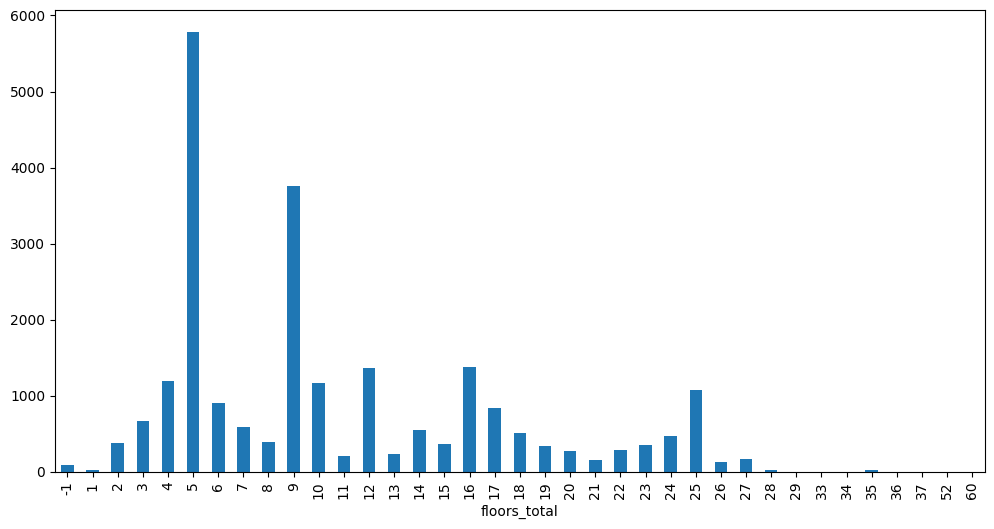

In [42]:
df.floors_total.fillna(-1).astype('int64').value_counts().sort_index().plot(kind='bar', figsize=(12, 6));

Эта столбиковая диаграмма показывающая в скольки этажных зданиях чаще всего продаются квартиры подверждает предыдущие выводы, чаще всего люди хотят избавиться от квартир в старых 5ти этажных домах. -1 - NA значения.

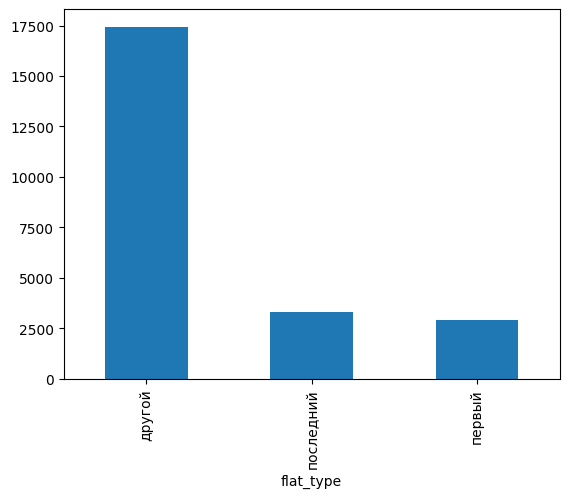

In [43]:
df.flat_type.value_counts().plot(kind='bar');

Странно, но получается что квартир на последнем этаже продается чуть больше чем на первом.

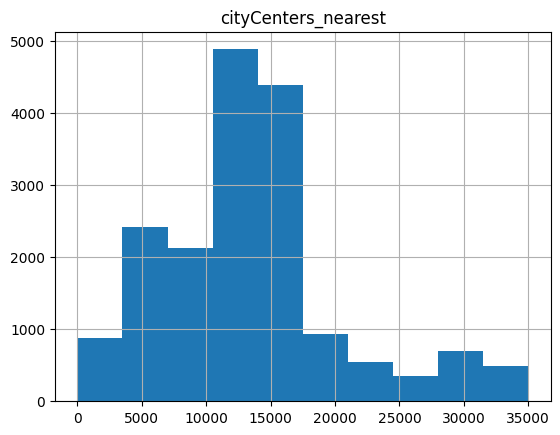

In [44]:
df.hist('cityCenters_nearest', range=(0, 35000));

На графике видно что большинство квартир продаются в пределах 15 км от центра города. Распределение напоминает нормальное.

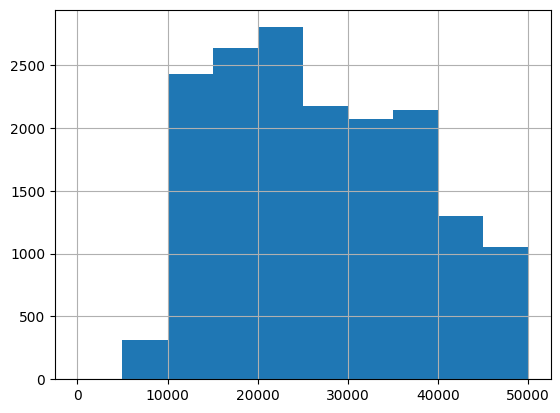

In [45]:
df.airports_nearest.hist(range=(0, 50000));

На графике видно что ближе чем на 5 км от аэропорта никто не живет, скорее всего есть какие-то нормативные ограничения. В основном квартиры продаются в 15-20 километрах от аэропорта.

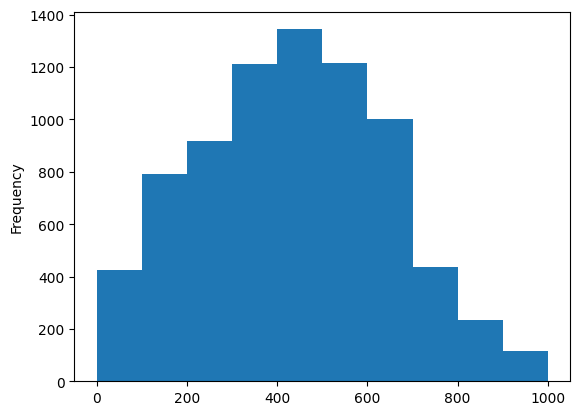

In [46]:
df.parks_nearest.plot(kind='hist', range=(0, 1000));

Удивляет то что в большинстве случаев в пределах полукилометра есть парк.

Все распределения скошены влево, как уже упоминалось. По столбцам картина следующая:
- total_area - видно что подавляющее большинство продваемых квартир меньше 100 $m^2$. Присутствует категория квартир менее 25 метров, скорее всего это комнаты в коммуналках
- living_area - менее 50 $m^2$
- kitchen_area - менее 20 $m^2$. Есть много объявлений где кухня менее 8 $m^2$.
- last_price - менее 5 миллионов рублей, если уменьшить диапазон значений, то распределение становится почти нормальным, с пиком в области 3-4 миллионов рублей.
- rooms - в основном 3 и меньше комнат. Больше всего на рынке 1 и 2 комнатных квартир. Также присутствует небольшое количество студий и квартир свободной планировки, всего 197 штук.
- медиана высоты потолков 2.65 метра, потолки выше 4х метров встречаются очень редко
- половина продавамых квартир находятся ниже 5го этажа, наверное свяано с тем что люди, в основном, хотят улучшить свои жилищные условие и поменять на что либо получше, люди пытаются избавиться от квартир в старых домах бабушатниках. Интересно что квартир на первом продается меньше чем на втором.
- более половины зданий в которых продаются квартиры до 15 этажей. Рекордсмены по количеству продаваемых квартир пятиэтажки.
- более половины предложений на рынке недвижимости находится от 5 до 20 км. от центра города, что вписывается в представления о многоэтажных окраинах питера и ленобласти
- рядом с аэропортом почти никто не живёт, подавляющее большинство предложений от 5 до 60 км от аэропорта
- удивило то что в подавляющем болшинстве случаев в пределах 1 км. есть парк

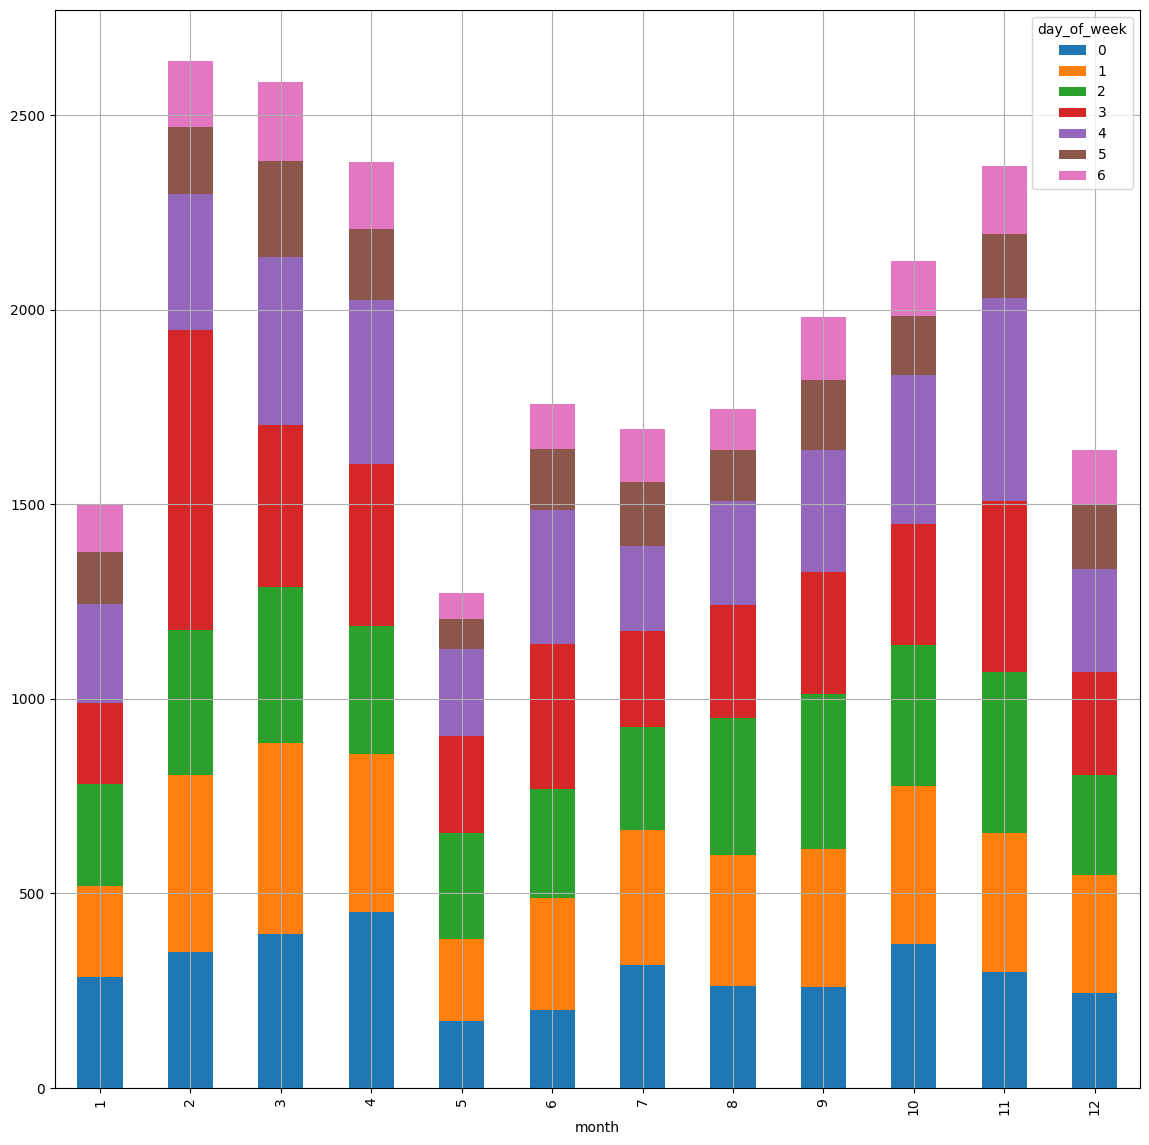

In [47]:
# Построим отдельно график для дня и месяца публикации объявления, 
# поскольку он требует дополнительных вычислений
month_day = df[['month', 'day_of_week']].value_counts().sort_index().unstack()
month_day.plot(kind='bar', stacked=True, figsize=(14,14), grid=True);

Минимальное количество объявлений приходится на праздничные месяцы январь, май и декабрь. Аномально большое количество предложений было зарегестрировано по четвергам февраля. В лидерах по количеству выставленных объявлений февраль, март и апрель. Минимальное количество объялений ожидаемо публикуется в выходные, когда риелторы не работают.

#### Как быстро продавались квартиры

count    20503.000000
mean       180.849778
std        219.645151
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

median 95.0


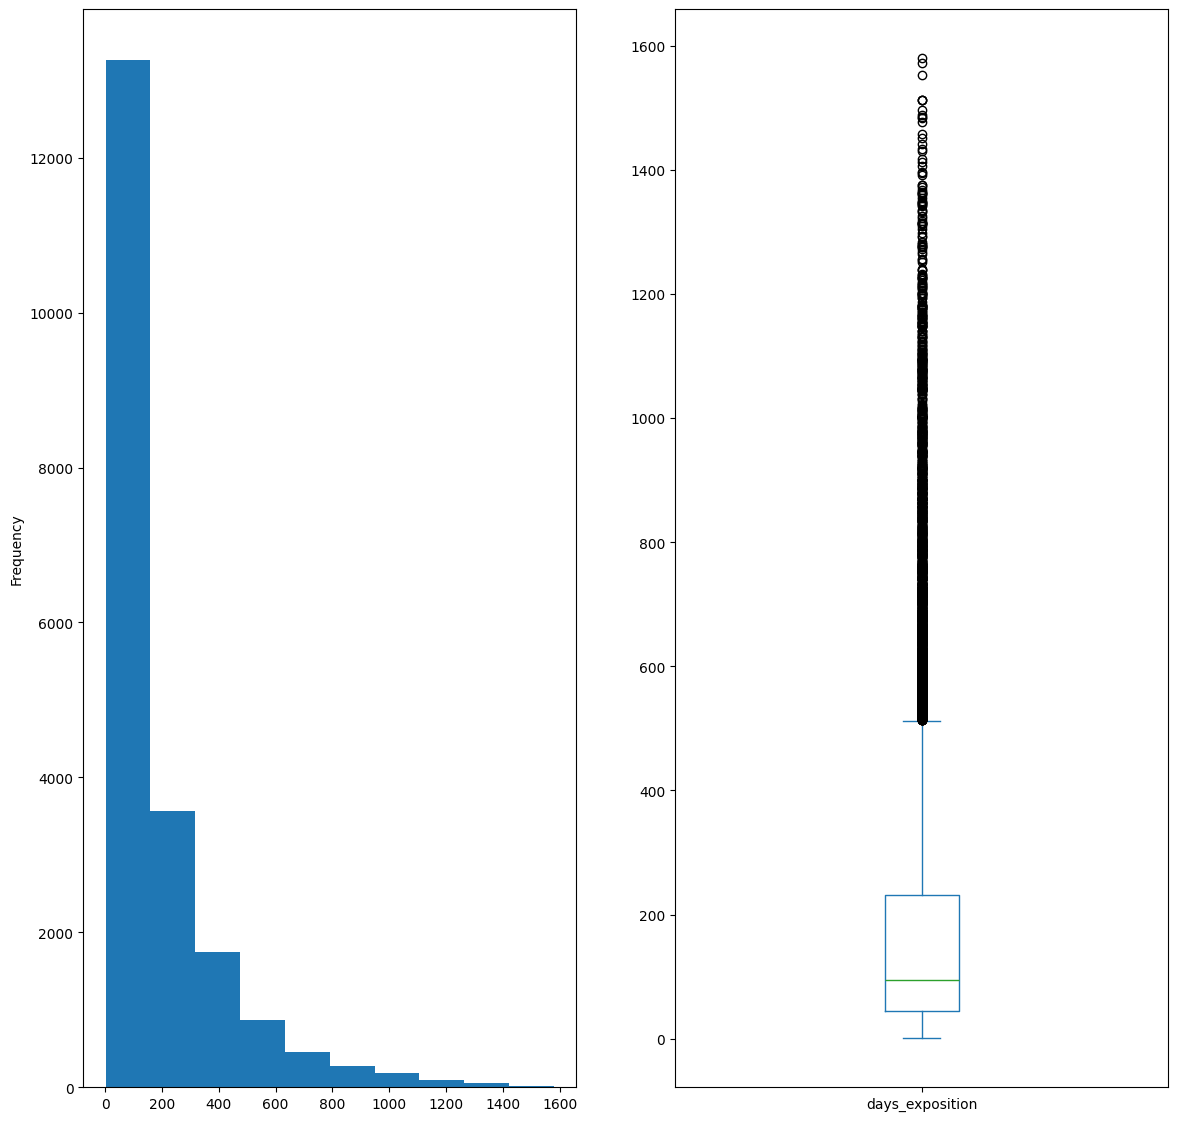

In [48]:
fig, axis = plt.subplots(1, 2, figsize=(14,14))
df.days_exposition.plot(kind='hist', ax=axis[0])
df.days_exposition.plot(kind='box', ax=axis[1])
display(df.days_exposition.describe())
print('median', df.days_exposition.median())

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

Давай тут уменьшим range до 100 или 200 (ведь именно в эти дни происходят основные продажи), возможно тут есть интересные аномалии. Так же в таких моментах лучше делать колличество корзин = колличеству дней (в соответствии с range)
</div>

count    20503.000000
mean       180.849778
std        219.645151
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

median 95.0


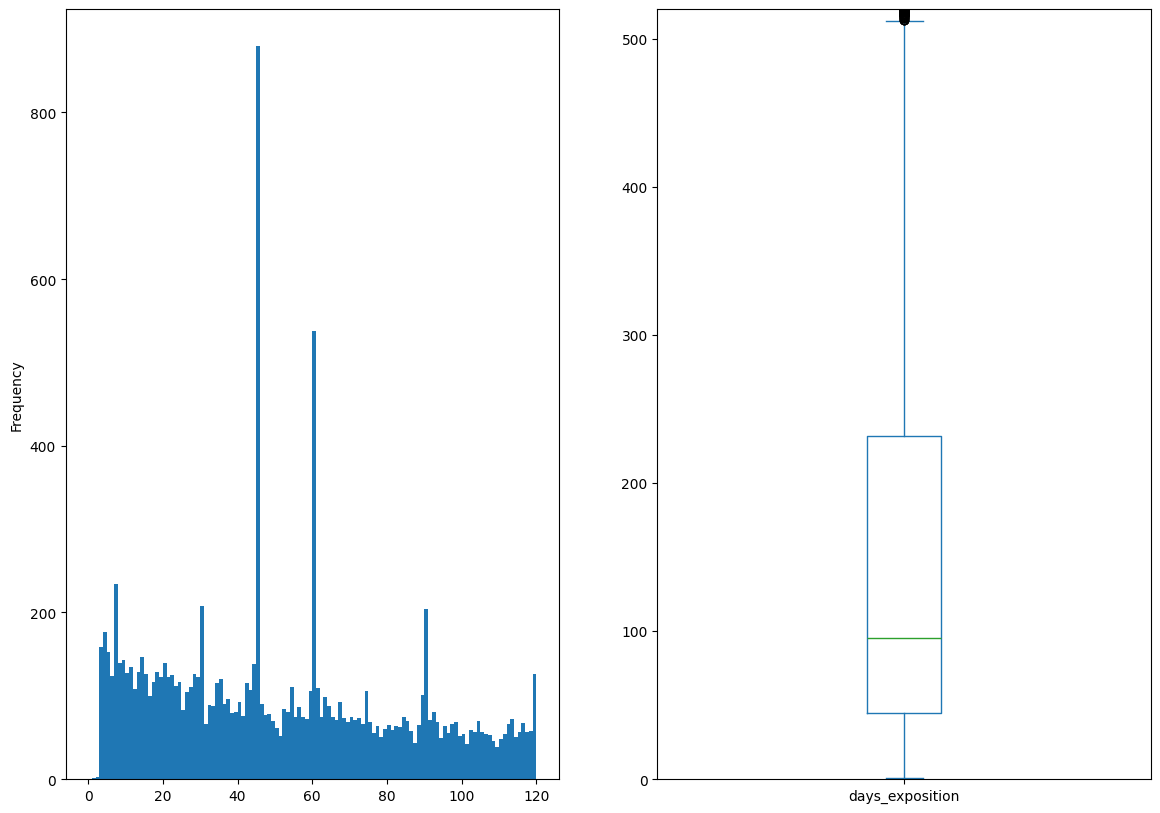

In [49]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 2, figsize=(14,10))
df.days_exposition.plot(kind='hist', range=(0,120), bins=120, ax=axis[0])
df.days_exposition.plot(kind='box', ylim=(0,520), ax=axis[1])
display(df.days_exposition.describe())
print('median', df.days_exposition.median())

На гистограмме видны аномальные пики, могу только предположить что возможно это как-то связано со сроками оформления документов и ипотечных кредитов. По диаграмме размаха можно сказать что половина квартир продаётся менее чем за 100 дней, а 75% менее чем за 210 дней.

#### Факторы влияющие на стоимость

In [50]:
df['flat_type'].unique()

array(['другой', 'первый', 'последний'], dtype=object)

total_area      0.681970
living_area     0.566639
kitchen_area    0.500489
rooms           0.385243
day_of_week     0.001249
month          -0.003348
year           -0.049753
dtype: float64
[0 1 2] Index(['другой', 'первый', 'последний'], dtype='object')
корреляция типа этажа -0.004645698144349092


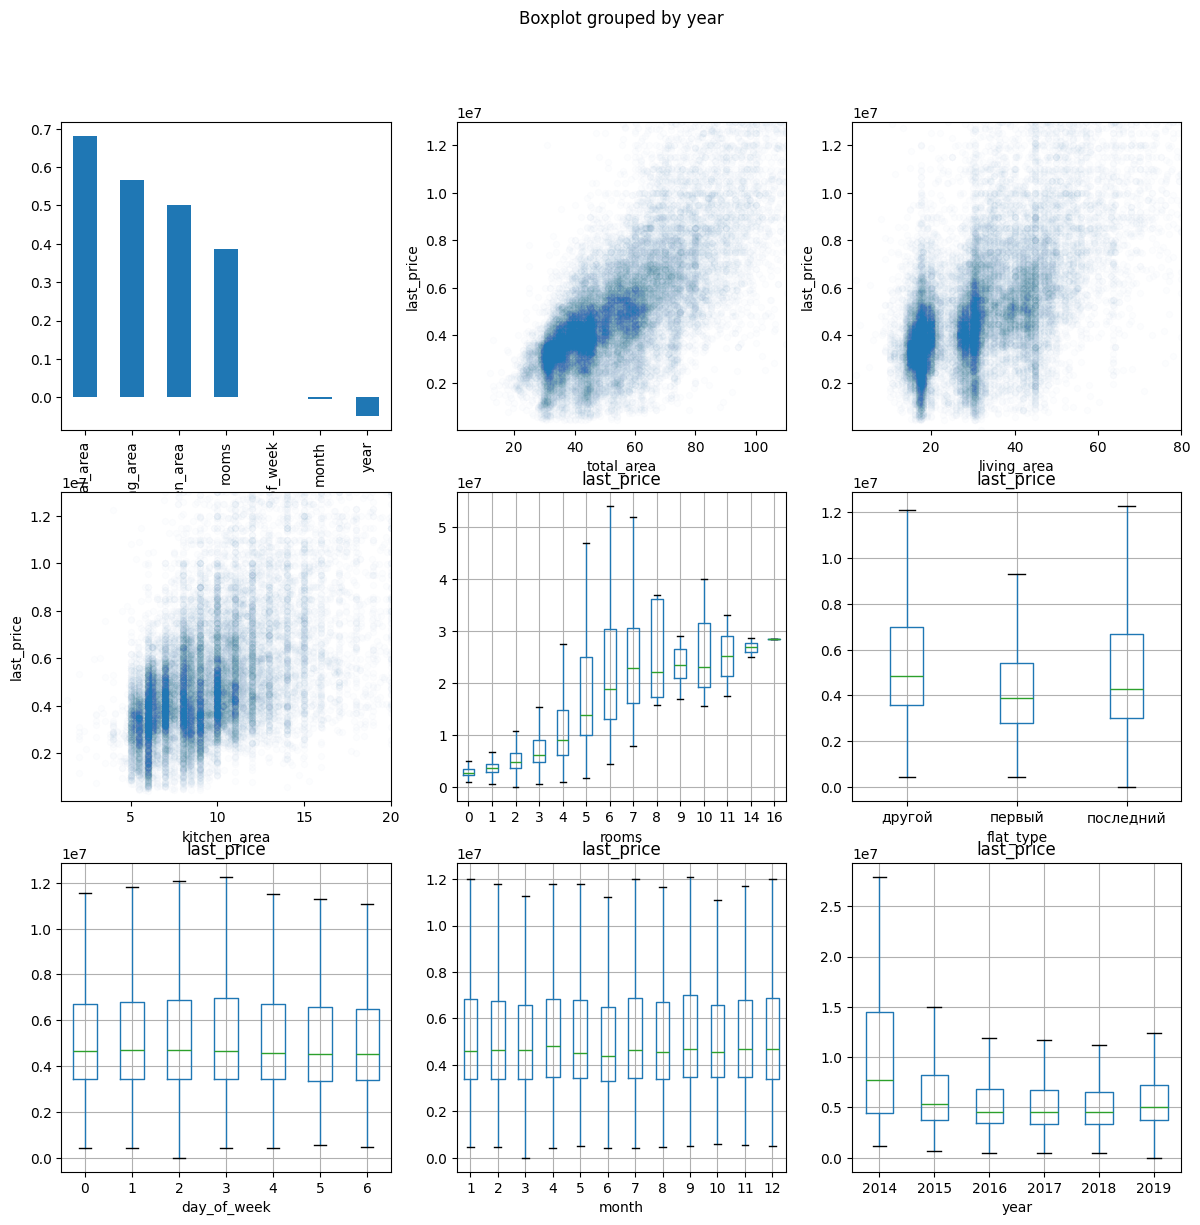

In [51]:
"""общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год)."""
import matplotlib.pyplot as plt
import numpy as np
fig, axis = plt.subplots(3, 3, figsize=(14,14))

df[['total_area', 'living_area', 'kitchen_area', 'rooms', 
    'day_of_week', 'month', 'year']].corrwith(df.last_price).plot(kind='bar', ax=axis[0,0])
df.plot.scatter('total_area', 'last_price', alpha=0.01, ylim=(1, 1.3e7), xlim=(1, 110), sharex=False, ax=axis[0,1])
df.plot.scatter('living_area', 'last_price', alpha=0.01, ylim=(1, 1.3e7), xlim=(1, 80), sharex=False, ax=axis[0,2])
df.plot.scatter('kitchen_area', 'last_price', alpha=0.01, ylim=(1, 1.3e7), xlim=(1, 20), sharex=False, ax=axis[1,0])
df.boxplot(column = 'last_price', by='rooms', showfliers=False, ax=axis[1,1])
df.boxplot(column = 'last_price', by='flat_type', showfliers=False, ax=axis[1,2])
df.boxplot(column = 'last_price', by='day_of_week', showfliers=False, ax=axis[2,0])
df.boxplot(column = 'last_price', by='month', showfliers=False, ax=axis[2,1])
df.boxplot(column = 'last_price', by='year', showfliers=False, ax=axis[2,2])
print(df[['total_area', 'living_area', 'kitchen_area', 'rooms', 
      'day_of_week', 'month', 'year']].corrwith(df.last_price))
data, index = pd.factorize(df['flat_type'], sort=True)
print(np.unique(data), index)
print("корреляция типа этажа", pd.Series(data = data).corr(df['last_price']))

Наибольшее влияние на стоимость оказывает столбец total_area, коэффициент корреляции почти 0.7, с натяжкой можно сказать что это сильная корелляция. Среднее влияние на стоимость оказывают столбцы living_area и kitchen_area, умеренно влияет rooms. Это видно по столбчатой диаграмме и другим графикам представленным на рисунке. Влиянием остальных столбцов можно пренебречь.

#### Топ 10 городов по стоимости квадратного метра

In [52]:
df[df.locality_name.isin(
    df['locality_name'].value_counts()[0:10].index)
  ].pivot_table(
        index='locality_name',
        values='sq_meter_price',
        aggfunc='mean'
    ).sort_values(by='sq_meter_price')

,sq_meter_price
locality_name,
выборг,58141.909153
всеволожск,68654.473986
гатчина,68746.146763
колпино,75424.579098
посёлок шушары,78677.364217
посёлок мурино,86087.512050
посёлок парголово,90175.913458
деревня кудрово,95324.930544
пушкин,103125.819291


Из таблицы видно что самая большая цена в Санкт-Петербурге - 114539 рублей за $m^2$, а минимальная в Выборге - 58141 руб за $m^2$.

#### Стоимость киллометра до центра города

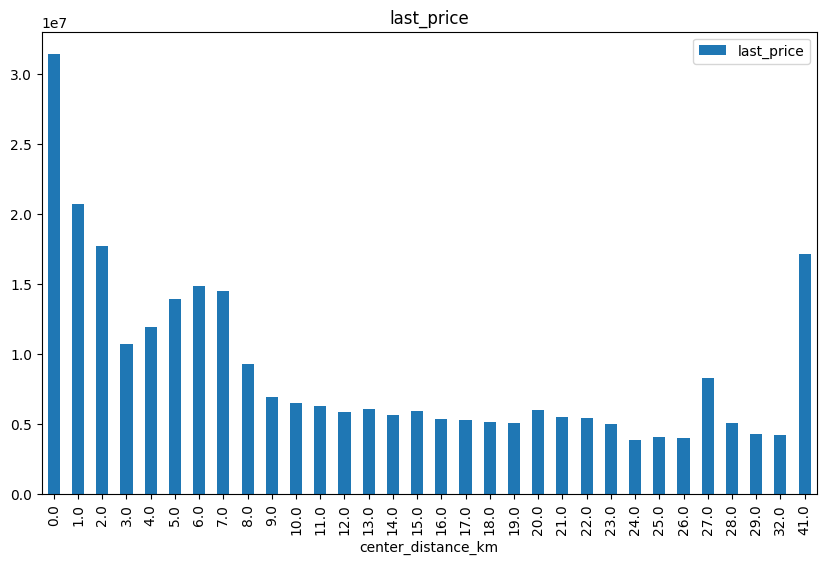

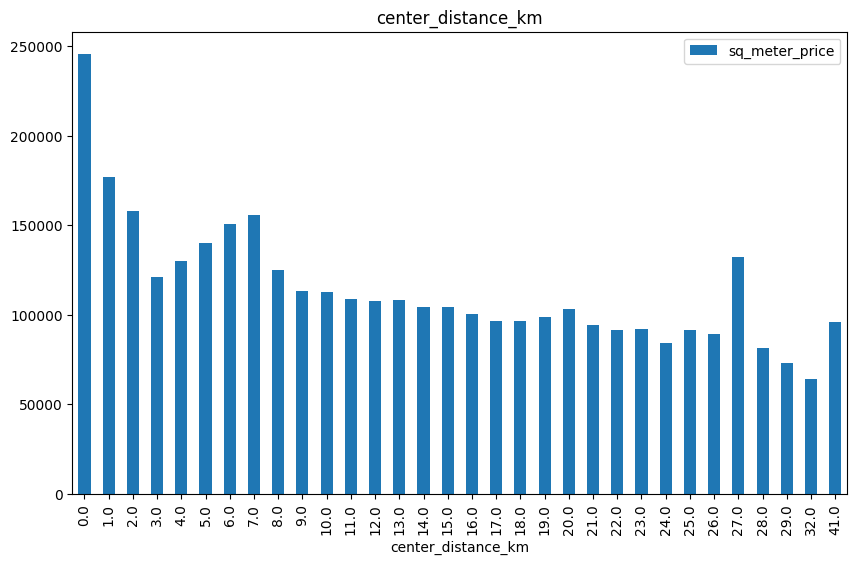

In [53]:
df[df.locality_name=='санкт-петербург'].pivot_table(
    index='center_distance_km', 
    values='last_price',
    aggfunc='mean'
).plot(kind='bar', figsize=(10, 6), title='last_price');
df[df.locality_name=='санкт-петербург'].pivot_table(
    index='center_distance_km', 
    values='sq_meter_price',
    aggfunc='mean'
).plot(kind='bar', figsize=(10, 6), title='center_distance_km');

На графиках ожидаемо видно что чем дальше от центра города, тем дешевле жильё. Однако интересно отметить что разница между 11 и, например, 20 киллометрами не велика, более того если посмотреть на стоимость квадратного метра в 3х километрах от центра, то она тоже не сильно отличается от стоимости в 20ти километрах, скорее всего это объясняется аварийным состоянием жилья. На графиках также видно всплески, возможно это дорогие новостройки или элитные посёлки.

### Общий вывод

В ходе работы был проанализирован датасет содержащий в себе данные об объявлениях по недвижимости. В 14 столбцах,не хватало данных, они были по возможности заполнены медианными значениями основываясь на количестве комнат и этажности: высота потолков, жилая площадь, полезная жилая площадь, площадь кухни, количество балконов. Пропуски в столбце город были заполнены значением "Санкт-Петербург" как наиболее вероятным. Также очень много пропусков было в бинарных столбцах апартаменты, открытая планировка и студия, пропуски в этих столбцах были заменены на False, исходя из предположения что квартир соответствующих этим параметрам довольно мало, и это указывают в объявлении. Оставшиеся столбцы рассчитывались исходя из адреса/координат поэтому заполнение не представлялось возможным. Пропуски скорее всего объясняются тем что в форме для создания объявления соответсвующие поля не являются обязательными и у них отсутствуют значения по умолчанию, соответственно база данных автоматически проставляет NULL. В процессе работы также столкнулся с тем что неправильно распарсились типы столбцов апартаменты, который был приведен к булевому типу и дата первой публикации, который был приведен к типу дата. Для удаления неявных дубликатов была использована функция Левенштейна, что помогла автоматизировать процесс их нахождения. В ручную такой объём проверить было бы тяжело. Далее после анализа диаграм размаха была удалена часть выбросов из столбца полезная площадь и аномальные значения из столбца высота потолков.

Следующим этапом работы было добавление новых столбцов: цена одного квадратного метра, день недели публикации объявления (0 — понедельник, 1 — вторник и так далее), месяц публикации объявления, год публикации объявления, тип этажа квартиры (значения — «первый», «последний», «другой») и расстояние до центра города в километрах.

На этапе исследовательского анализа данных первый график это столбчатая диаграмма которая показывает количество объявлений в зависимости от месяца и дня недели. Из неё видно что минимальное количество объявлений приходится на праздничные месяцы январь, май и декабрь. Аномально большое количество предложений было зарегестрировано по четвергам февраля. В лидерах по количеству выставленных объявлений февраль, март и апрель. Минимальное количество объялений ожидаемо публикуется в выходные, когда риелторы не работают.

Следующий график это скорость продажи квартир. Половина квартир продаётся за менее чем 3 месяца, среднее время продажи пол года, но оно не совсем репрезентативно, так как в выборке есть выбросы. 3/4 квартир продаётся менее через 8 месяцев, рекордсмены продаются по нескольку лет.

Для исследования влияния различных параметров на стоимость было построено 3 типа графиков: столбчатая диаграма, для визуализации коэффициентов корреляции между столбцами и последней ценой, график hexbin, для количественных данных и диаграмма размаха, для категориальных переменных. Наибольшее влияние на стоимость оказывает столбец жилая площадь, коэффициент корреляции почти 0.7, с натяжкой можно сказать что это сильная корелляция. Среднее влияние на стоимость оказывают столбцы полезная площадь и площадь кухни, умеренно влияет количество комнат. Влиянием переменных этажность, день недели, месяц и год можно пренебречь.

Затем был составлен топ 10 рейтинг самых дорогих городов Петербурга и области по стоимости квадратного метра. Самая большая цена в Санкт-Петербурге - 114539 рублей за $m^2$, а минимальная в Выборге - 58141 руб за $m^2$.

Наконец была рассчитана стоимость километра до центра города, используя последню стоимость и стоимость за квадратный метр. Для визуализации были построены столбчатые диаграммы. На графиках ожидаемо видно что чем дальше от центра города, тем дешевле жильё. Однако интересно отметить что разница между 11 и, например, 20 киллометрами не велика, более того если посмотреть на стоимость квадратного метра в 3х километрах от центра, то она тоже не сильно отличается от стоимости в 20ти километрах, скорее всего это объясняется аварийным состоянием жилья. На графиках также видно всплески, возможно это дорогие новостройки или элитные посёлки.

В целом единственным неожиданным открытием стало то что цена не сильно меняется в зависимости от удаления от центра города, резкие скачки конечно есть, примеры в предыдущем абзаце. Объясняется ли это плохим состоянием старых многоквартирных домов, большим количество коммуналок в центре города или другими причинами? Вопрос остаётся открытым. 

Рынок недвижимости Санкт-Петербурга перенасыщен предложениями в старых домах, это объясняет небольшое различие между ценами на к примеру третьем километре от центра в сравнении даже с 20м. Это было показано на столбиковых диаграммах в разделе 4.1, распределение продаваемых квартир по этажам и распределение продаваемых квартир по этажности здания. Также можно отметить что у большинства продаваемых квартир есть парк в пределах 1 километра.